b) Läs in 10 bilder slumpmässigt, plotta dem och extrahera deras labels och skriv ut i titeln.

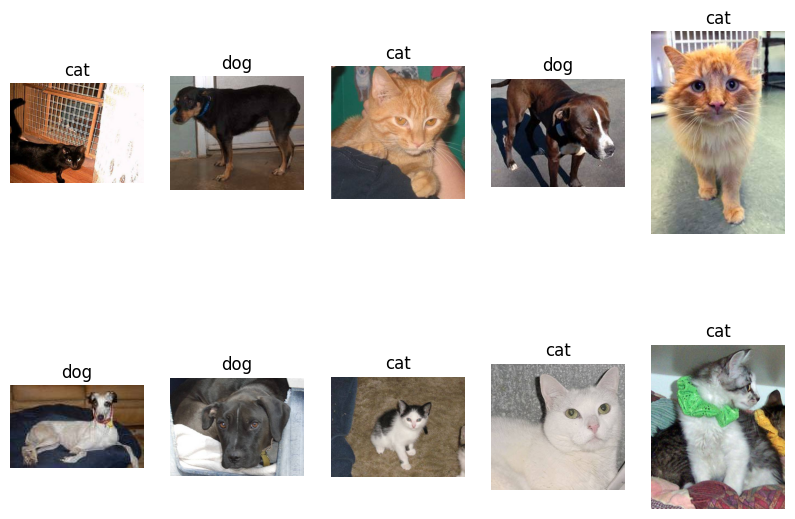

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from sklearn.preprocessing import LabelBinarizer
from pathlib import Path
import random


current_path= Path().absolute()        
test_path= current_path/"original_data"/"test"
train_path= current_path/"original_data"/"train"

train_list = list(train_path.iterdir())
test_list = list(test_path.iterdir())

pictures = np.random.choice(train_list, 10, replace=False)

pattern = r"\b\w{3}\b"
labels = [re.findall(pattern, path.name)[0] for path in pictures]

fig, axes = plt.subplots(2, 5, figsize=(10, 7))
for i, ax in enumerate(axes.flatten()):
    image_path = pictures[i] 
    image = plt.imread(image_path) 
    ax.imshow(image)
    ax.set_title(labels[i])
    ax.axis("off")

plt.show()


In [5]:
"""

# Definiera de olika sökvägarna
experiment_small_data = Path("experiment_small_data")
experiment_tiny_data = Path("experiment_tiny_data")
original_data = Path("original_data")


# Skapa mappstrukturen
experiment_small_data.mkdir(parents=True, exist_ok=True)
experiment_tiny_data.mkdir(parents=True, exist_ok=True)
(original_data / "test" / "test").mkdir(parents=True, exist_ok=True)
(original_data / "train" / "train").mkdir(parents=True, exist_ok=True)

#Skapa undermappar i experiment_small_data och experiment_tiny_data
for folder in ["test", "train", "val"]:
    (experiment_small_data / folder).mkdir(exist_ok=True)
    (experiment_tiny_data / folder).mkdir(exist_ok=True)

# bugtest så vi vet om något går fel
for item in Path(".").rglob("*"):
     print(item) 

"""

experiment_small_data
experiment_tiny_data
Lab2_DL.pdf
Labb2.ipynb
original_data
experiment_small_data\test
experiment_small_data\train
experiment_small_data\val
experiment_tiny_data\test
experiment_tiny_data\train
experiment_tiny_data\val
original_data\test
original_data\train
original_data\test\1.jpg
original_data\test\10.jpg
original_data\test\100.jpg
original_data\test\1000.jpg
original_data\test\10000.jpg
original_data\test\10001.jpg
original_data\test\10002.jpg
original_data\test\10003.jpg
original_data\test\10004.jpg
original_data\test\10005.jpg
original_data\test\10006.jpg
original_data\test\10007.jpg
original_data\test\10008.jpg
original_data\test\10009.jpg
original_data\test\1001.jpg
original_data\test\10010.jpg
original_data\test\10011.jpg
original_data\test\10012.jpg
original_data\test\10013.jpg
original_data\test\10014.jpg
original_data\test\10015.jpg
original_data\test\10016.jpg
original_data\test\10017.jpg
original_data\test\10018.jpg
original_data\test\10019.jpg
origina

d) Nu ska du göra train|val|test split med följande splits:

experiment_small
* train - 1600 (800 dogs, 800 cats)
* val - 400 (200 dogs, 200 cats)
* test - 500 (250 dogs, 250 cats)

experiment_tiny (BONUS)
* train - 160 (80 dogs, 80 cats)
* val - 40 (20 dogs, 20 cats)
* test - 50 (25 dogs, 25 cats

In [23]:
def count_files(directory):
    """ Count all files in the given directory. """
    return sum(1 for item in directory.iterdir() if item.is_file())

def sample_and_move_files(source_path, target_path, splits):
    """ Samples files from the source directory and moves them to the target directory based on the provided splits. """
    # Ensure target subdirectories exist
    for subset in splits.keys():
        (target_path / subset).mkdir(parents=True, exist_ok=True)

    # Move files based on the splitting configuration
    for subset, numbers in splits.items():
        target_folder = target_path / subset
        total_needed = sum(numbers.values())
        current_count = count_files(target_folder)

        if current_count >= total_needed:
            print(f"Skipping {subset} as it already contains the maximum number of files ({current_count}/{total_needed}).")
            continue

        print(f"Starting to process {subset}:")
        # Sampling files
        dogs = list(source_path.glob("*dog*"))
        cats = list(source_path.glob("*cat*"))
        sampled_dogs = random.sample(dogs, numbers["dogs"])
        sampled_cats = random.sample(cats, numbers["cats"])

        # Moving files
        def move_files(files, category, animal):
            target_folder = target_path / category
            for file in files:
                if file.exists():
                    shutil.move(str(file), str(target_folder))
                    print(f"Moved {animal} file {file.name} to {category}")

        move_files(sampled_dogs, subset, "dogs")
        move_files(sampled_cats, subset, "cats")

        # After moving files, check if we've reached the limit
        if count_files(target_folder) >= total_needed:
            print(f"Reached the target number of files for {subset}: {total_needed} files.")

        print(f"Completed processing {subset}.")

# Setup paths
current_path = Path().absolute()
original_train = current_path / "original_data/train"
small_data = current_path / "experiment_small_data"
tiny_data = current_path / "experiment_tiny_data"

# Define the splits for small and tiny datasets
splits_small = {
    "train": {"dogs": 800, "cats": 800},
    "val": {"dogs": 200, "cats": 200},
    "test": {"dogs": 250, "cats": 250}
}

splits_tiny = {
    "train": {"dogs": 80, "cats": 80},
    "val": {"dogs": 20, "cats": 20},
    "test": {"dogs": 25, "cats": 25}
}

# Perform the sampling and moving for small data
sample_and_move_files(original_train, small_data, splits_small)
# Perform the sampling and moving for tiny data
sample_and_move_files(original_train, tiny_data, splits_tiny)


Skipping train as it already contains the maximum number of files (1600/1600).
Skipping val as it already contains the maximum number of files (400/400).
Skipping test as it already contains the maximum number of files (500/500).
Skipping train as it already contains the maximum number of files (160/160).
Skipping val as it already contains the maximum number of files (40/40).
Skipping test as it already contains the maximum number of files (50/50).


---

 e) Läs in dataseten från experiment_small, experiment_tiny (BONUS) och plocka ut labelsvektorer, som
ska vara one-hot encoded med 0 och 1.
* plotta några bilder med deras respektive labels och kontrollera att det är korrekt.
* skapa lämplig plot för att kontrollera att dataseten är balanserade
* skapa lämplig plot för att kontrollera att dataseten är slumpade

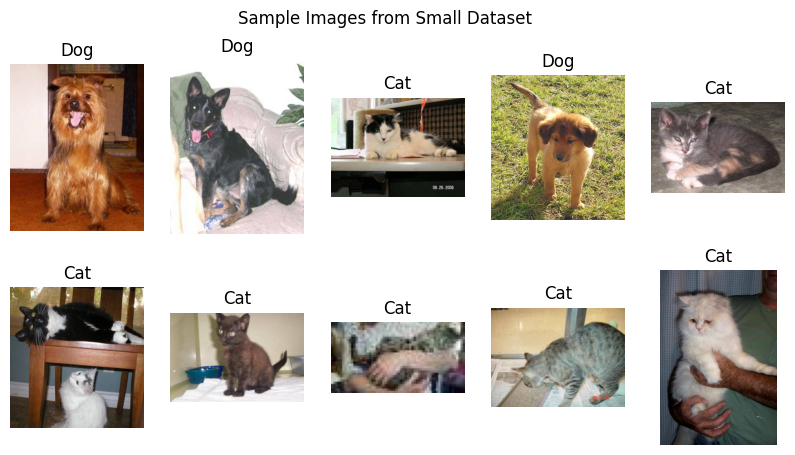

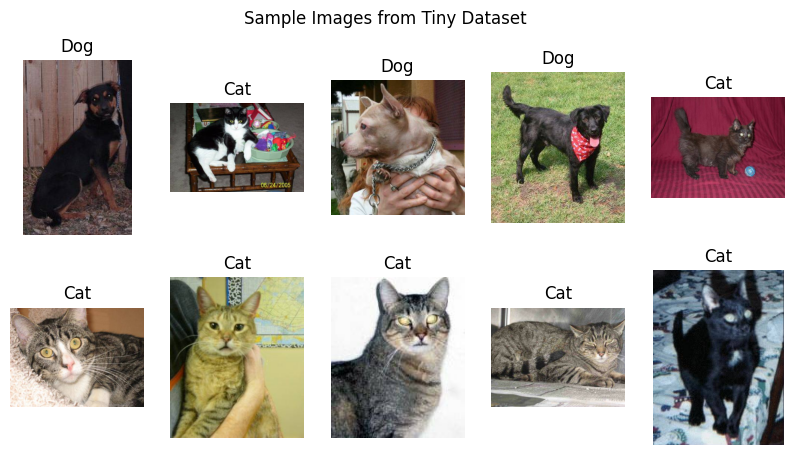

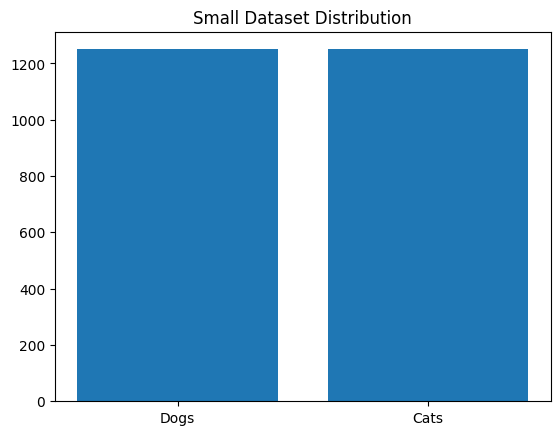

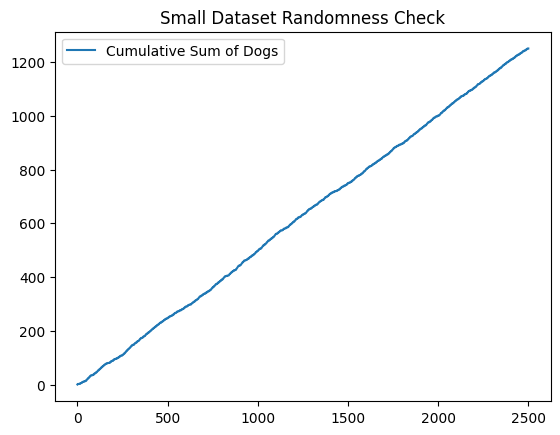

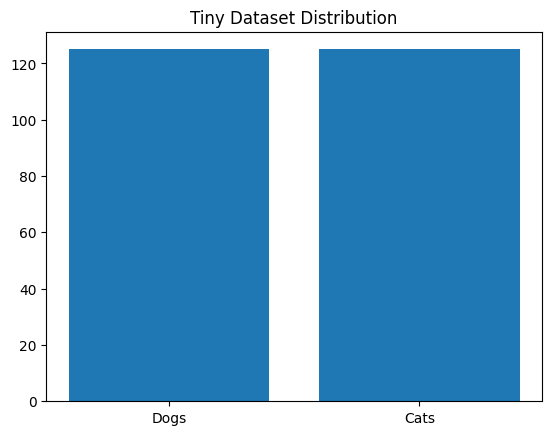

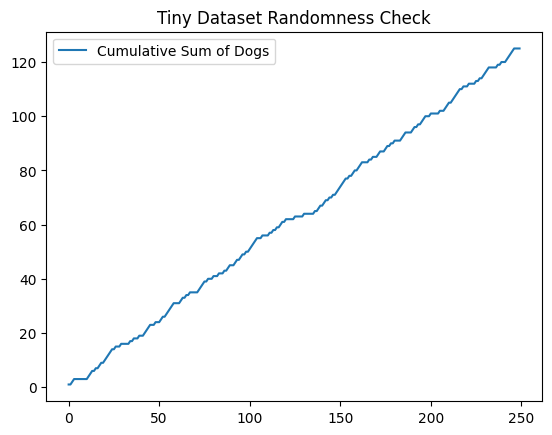

In [26]:


experiment_small_data = Path("experiment_small_data")
experiment_tiny_data = Path("experiment_tiny_data")
original_data = Path("original_data")

def load_data_and_labels(data_path):
    images = []
    labels = []
    for category in ["train", "val", "test"]:
        cat_dir = data_path / category
        files = list(cat_dir.glob("*"))
        random.shuffle(files)  # Shuffle the list to randomize file order
        for image_path in files:
            images.append(imread(str(image_path)))
            file_name = image_path.name.lower()
            if "dog" in file_name:
                labels.append("dog")
            elif "cat" in file_name:
                labels.append("cat")
    lb = LabelBinarizer()
    labels = lb.fit_transform(labels)
    labels = np.array(labels)
    return images, labels, files

images_small, labels_small, files_small = load_data_and_labels(experiment_small_data)
images_tiny, labels_tiny, files_tiny = load_data_and_labels(experiment_tiny_data)

def plot_images_with_labels(images, labels, title):
    plt.figure(figsize=(10, 5))
    for i in range(min(10, len(images))):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i])
        plt.title("Dog" if labels[i, 0] == 1 else "Cat")
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

plot_images_with_labels(images_small, labels_small, "Sample Images from Small Dataset")
plot_images_with_labels(images_tiny, labels_tiny, "Sample Images from Tiny Dataset")

def plot_label_distribution(labels, title):
    dog_count = np.sum(labels[:, 0] == 1)
    cat_count = len(labels) - dog_count
    plt.bar(["Dogs", "Cats"], [dog_count, cat_count])
    plt.title(title + " Distribution")
    plt.show()
    plt.plot(np.cumsum(labels[:, 0]), label="Cumulative Sum of Dogs")
    plt.title(title + " Randomness Check")
    plt.legend()
    plt.show()

plot_label_distribution(labels_small, "Small Dataset")
plot_label_distribution(labels_tiny, "Tiny Dataset")


---
# 1. Bildbehandling (*)
Uppgifterna nedan ska upprepas för respektive experimentdataset om du också väljer att arbeta med
tinydatasetet.

 a) Skapa en plot för att visualisera bildstorlekarna i träningsdatan. Använd seaborns jointplot.

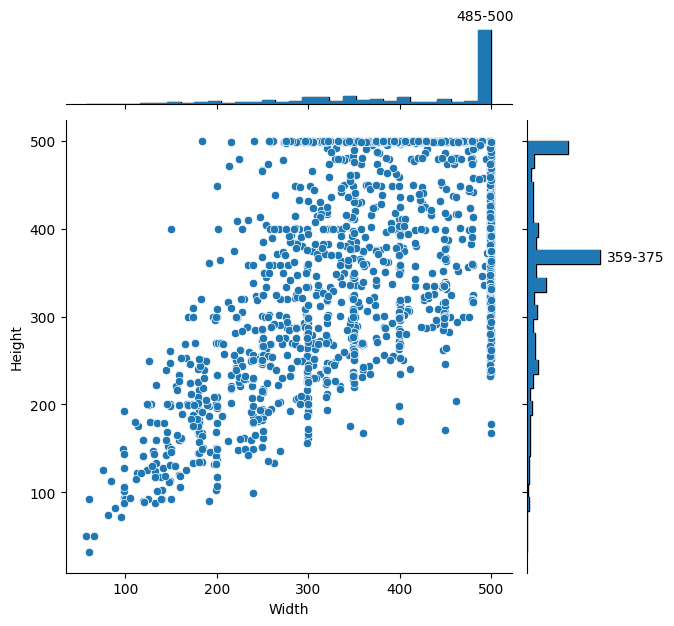

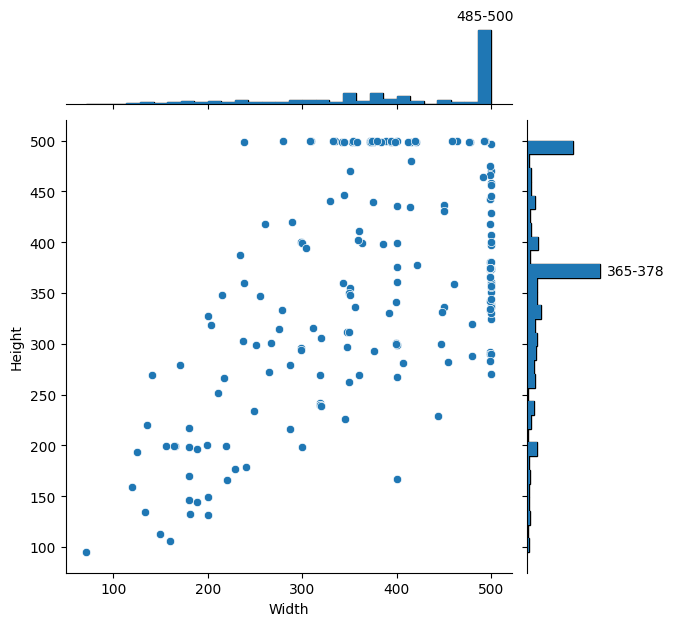

In [33]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.image import imread

def get_image_sizes(data_path):
    """Gather image dimensions for images in the specified directory."""
    sizes = []
    categories = ['train', 'val', 'test']
    for category in categories:
        cat_dir = data_path / category
        files = list(cat_dir.glob("*"))
        for image_path in files:
            img = imread(str(image_path))
            if len(img.shape) == 3:
                height, width, _ = img.shape
                sizes.append((width, height))
    return sizes

def plot_image_sizes(sizes, title):
    """Plot the image sizes using a jointplot and annotate the highest histogram bars with bin range."""
    widths, heights = zip(*sizes)
    widths = np.array(widths)
    heights = np.array(heights)

    # Create jointplot
    joint_plot = sns.jointplot(x=widths, y=heights, kind='scatter', marginal_kws=dict(bins=30, fill=True))
    plt.xlabel('Width')
    plt.ylabel('Height')
    plt.suptitle(title)

    # Annotate the highest bar in the x histogram
    n, bins, patches = joint_plot.ax_marg_x.hist(widths, bins=30, fill=True)
    max_idx = np.argmax(n)
    max_bin_start = bins[max_idx]
    max_bin_end = bins[max_idx + 1]
    joint_plot.ax_marg_x.annotate(f'{int(max_bin_start)}-{int(max_bin_end)}', xy=((max_bin_start + max_bin_end) / 2, max(n)), xytext=(0, 5), textcoords='offset points', ha='center', va='bottom')

    # Annotate the highest bar in the y histogram
    n, bins, patches = joint_plot.ax_marg_y.hist(heights, bins=30, fill=True, orientation='horizontal')
    max_idx = np.argmax(n)
    max_bin_start = bins[max_idx]
    max_bin_end = bins[max_idx + 1]
    joint_plot.ax_marg_y.annotate(f'{int(max_bin_start)}-{int(max_bin_end)}', xy=(max(n), (max_bin_start + max_bin_end) / 2), xytext=(5, 0), textcoords='offset points', ha='left', va='center')

    plt.show()

# Setup paths
experiment_small_data = Path("experiment_small_data")
experiment_tiny_data = Path("experiment_tiny_data")

# Get sizes from each dataset
image_sizes_small = get_image_sizes(experiment_small_data)
image_sizes_tiny = get_image_sizes(experiment_tiny_data)

# Generate plots with annotations
plot_image_sizes(image_sizes_small, " ")
plot_image_sizes(image_sizes_tiny, "")


---


In [32]:
import numpy as np
from pathlib import Path
from PIL import Image
import os

def resize_and_load_images(data_path, target_size=(224, 224)):
    """
    Resize images to a uniform size and load them into a NumPy array.

    Args:
    data_path (Path): Path to the directory containing image subdirectories.
    target_size (tuple): Tuple indicating the new size (width, height).

    Returns:
    numpy.ndarray: Array of images with shape (samples, rows, cols, color_channels).
    """
    data_path = Path(data_path)
    categories = ['train', 'val', 'test']  # Example categories
    images = []
    for category in categories:
        cat_dir = data_path / category
        files = list(cat_dir.glob("*"))
        for image_path in files:
            img = Image.open(image_path)
            img = img.resize(target_size, Image.ANTIALIAS)  # Resize the image
            img_array = np.array(img)
            if img_array.ndim == 2:  # Convert grayscale to RGB
                img_array = np.stack([img_array]*3, axis=-1)
            images.append(img_array)
    
    return np.stack(images, axis=0)  # Stack images into a single numpy array

# Setup paths
data_path = Path("path_to_your_data_folder")

# Resize images and load into an array
image_data_array = resize_and_load_images(data_path)

# Optionally, save the array to disk for future use
np.save('resized_image_data.npy', image_data_array)

# Check the shape of the resulting array
print("Shape of the image data array:", image_data_array.shape)


ValueError: need at least one array to stack